In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

import ee

In [24]:
data = pd.read_csv('01_data.csv', index_col=0, parse_dates=True)
data.head()

,precip_in_inc,precip_in_cum,stage_ft_BT,flood_stage_BT,stage_ft_SC,flood_stage_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01 00:00:00,0.0,0.0,2.83,0.0,3.89,0.0,0.0,10.8,1.43,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:15:00,0.0,0.0,2.83,0.0,3.88,0.0,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:30:00,0.0,0.0,2.83,0.0,3.88,0.0,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:45:00,0.0,0.0,2.83,0.0,3.88,0.0,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 01:00:00,0.0,0.0,2.83,0.0,3.88,0.0,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0


## Random Forest Model
Build Random forest model with several variables lagged, to get general idea of feature importance and model fit capabilities as a baseline. 

In [25]:
data_rfr = data.copy()
months_to_lag = [1, 2, 3, 4] 
drought_index_ints = [0, 1, 2, 3, 4]

for m in months_to_lag:
    data_rfr['lag_precip_' + str(m) + 'months'] = data_rfr['precip_in_inc'].shift(-30*m) # shift data back, 30 days in a month
    for d in drought_index_ints:
        data_rfr['lag_d' + str(d) + '_' + str(m) + 'months'] = data_rfr['D' + str(d)].shift(-30*m) #shift back data

hours_to_lag = [1, 2, 5, 14, 30]
for h in hours_to_lag:
    data_rfr['lag_precip_' + str(h) + 'days'] = data_rfr['precip_in_inc'].shift(h) # shift data back h hours


data_rfr.dropna(inplace=True) #drop null values created with shift functions - will be most recent 4 months
data_rfr.head()


,precip_in_inc,precip_in_cum,stage_ft_BT,flood_stage_BT,stage_ft_SC,flood_stage_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,...,lag_d0_4months,lag_d1_4months,lag_d2_4months,lag_d3_4months,lag_d4_4months,lag_precip_1days,lag_precip_2days,lag_precip_5days,lag_precip_14days,lag_precip_30days
2008-10-01 07:30:00,0.0,0.0,2.85,0.0,3.86,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 07:45:00,0.0,0.0,2.85,0.0,3.85,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:00:00,0.0,0.0,2.85,0.0,3.85,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:15:00,0.0,0.0,2.86,0.0,3.85,0.0,0.0,12.2,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:30:00,0.0,0.0,2.86,0.0,3.85,0.0,0.0,12.2,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


training model score:  0.46438664306574284
test model score:  0.4665003309563107


<Axes: >

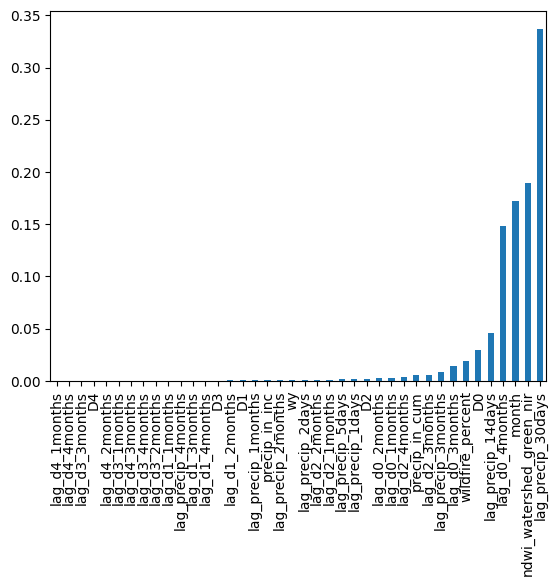

In [26]:
X = data_rfr.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_SC_int']
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_SC, y_train_SC)
y_pred_SC = rfr.predict(X_test_SC)

print('training model score: ', rfr.score(X_train_SC, y_train_SC))
print('test model score: ', rfr.score(X_test_SC, y_test_SC))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_SC.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


training model score:  0.4816408870159178
test model score:  0.47401725337682277


<Axes: >

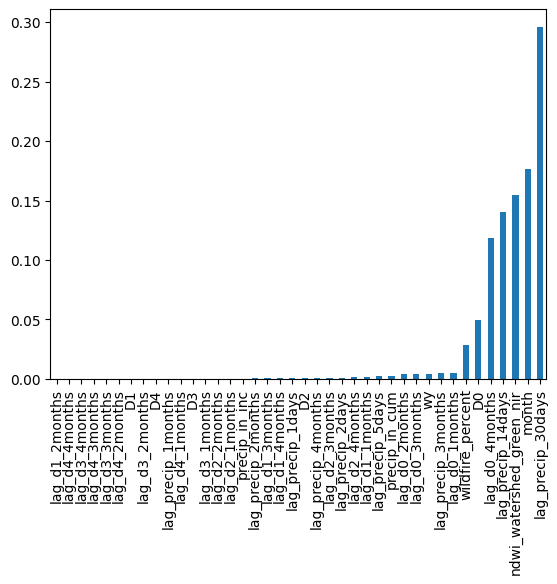

In [27]:
X = data_rfr.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_BT_int']
X_train_BT, X_test_BT, y_train_BT, y_test_BT = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_BT, y_train_BT)
y_pred_BT = rfr.predict(X_test_BT)
print('training model score: ', rfr.score(X_train_BT, y_train_BT))
print('test model score: ', rfr.score(X_test_BT, y_test_BT))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_BT.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


Text(0, 0.5, 'observed streamflow')

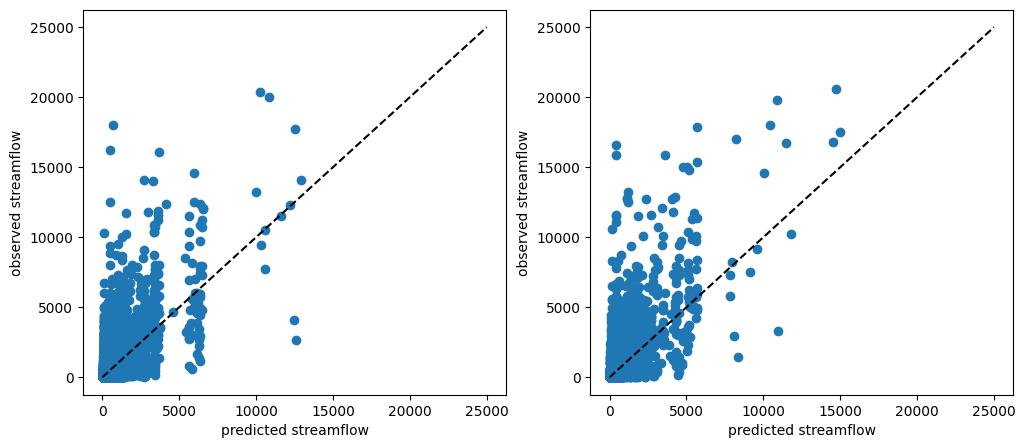

In [28]:
## plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_pred_BT, y_test_BT)
ax1.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax1.set_xlabel('predicted streamflow')
ax1.set_ylabel('observed streamflow')


ax2.scatter(y_pred_SC, y_test_SC)
ax2.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax2.set_xlabel('predicted streamflow')
ax2.set_ylabel('observed streamflow')

## RFR Results
Most importance features are: 
- precip and lag of precip is obviously most important model feature.

Model underpredicts flow peaks (typical of RFR)

RFR model appears to explain 85% of model variability (R_squared), but overfits in the train period (r_squared for test is 0.65)
Could possibly improve with different hyperparameters, but good first gut check model


## Random Forest Classifier of flood stage



In [31]:
y.unique()

array([0. , 1. , 2. , 3. , 4. , 0.5])

In [29]:
data_rfc = data_rfr.copy()


X = data_rfc.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfc['flood_stage_SC']
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.2, random_state=777)

rfc = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=777)
rfc.fit(X_train_SC, y_train_SC)
y_pred_SC = rfc.predict(X_test_SC)

print('training model score: ', rfc.score(X_train_SC, y_train_SC))
print('test model score: ', rfc.score(X_test_SC, y_test_SC))

#next, we'll take a look at feature importance
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=X_train_SC.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
X = data_rfc.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfc['flood_stage_BT']
X_train_BT, X_test_BT, y_train_BT, y_test_BT = train_test_split(X, y, test_size=0.7, random_state=777)

rfc_BT = RandomForestClassifier()
rfc_BT.fit(X_train_BT, y_train_BT)
y_pred_BT = rfc_BT.predict(X_test_BT)
print('training model score: ', rfc_BT.score(X_train_BT, y_train_BT))
print('test model score: ', rfc_BT.score(X_test_BT, y_test_BT))

#next, we'll take a look at feature importance
importances = rfc_BT.feature_importances_
forest_importances = pd.Series(importances, index=X_train_BT.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


In [ ]:
X
# X_train_BT

In [ ]:
## plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_pred_BT, y_test_BT)
ax1.plot((0, 4), (0, 4), 'k', linestyle='--')
ax1.set_xlabel('predicted flood stage')
ax1.set_ylabel('observed flood stage')


ax2.scatter(y_pred_SC, y_test_SC)
ax2.plot((0, 4), (0, 4), 'k', linestyle='--')
ax2.set_xlabel('predicted flood stage')
ax2.set_ylabel('observed flood stage')

## LSTM Model



In [ ]:
target = 'q_cfs_peak_BT_int'

In [ ]:
data_lstm = data.copy()

#have 15 years of data, split to train/test on 10/5 years. last 5 years include one wet, one dry, and 3 middlish years, so good variety to test on
data_lstm_test = data_lstm.loc[data_lstm.wy >= 2019, :] 
data_lstm_train = data_lstm.loc[data_lstm.wy < 2019, :]

X_train = data_lstm_train.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
X_test = data_lstm_test.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
## scale x data
scaler = MinMaxScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = data_lstm_train[target]
y_test = data_lstm_test[target]

scaler = MinMaxScaler().set_output(transform="pandas")
y_train = np.log(y_train)
y_test = np.log(y_test)





In [ ]:
#separate sequences from x and y data. 

def split_sequence(sequence, n_steps, target):
    X_out, y_out = list(), list() # initialize output

    for n in range(len(sequence) - n_steps + 1): #step through data, skipping last n_steps rows so all sequences are same size
        this_batch = sequence.iloc[n:n+n_steps, :]
        X_out.append(this_batch.drop([target], axis=1))
        y_out.append(this_batch[target])

    return np.array(X_out), np.array(y_out)

In [ ]:
#recombine X, y after scaling to make sure sequences are calculated correctly
xy_train = pd.concat([X_train, y_train], axis=1)
xy_test = pd.concat([X_test, y_test], axis=1)
n_steps = 240
X_train_seq, y_train_seq = split_sequence(xy_train, n_steps, target)
X_test_seq, y_test_seq = split_sequence(xy_test, n_steps, target)

In [ ]:
model = Sequential()
# col_num = np.array(X_train).shape[2]
# input_shape = (batch_size, time_steps, number_of_features)
#number_of_features = # of cols
# timesteps = window size 
# batch_size how many samples are input once reshaped
model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) #input shape
model.add(LSTM(100, return_sequences=True, go_backwards=True))
model.add(LSTM(100, return_sequences=True, go_backwards=False))
model.add(LSTM(50))
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit(X_train_seq, y_train_seq, epochs=5)

In [ ]:
y_pred = model.predict(X_test_seq)

In [ ]:
f, ax = plt.subplots(1, 1)
ax.plot(y_train)
ax.plot(xy_train.index, y_train)

f, ax = plt.subplots(1, 1)
ax.plot(y_test)
ax.plot(xy_test.index[n_steps-1::], y_pred)

## Daily Model

In [ ]:
data_lstm = data.resample('1d').median()

#have 15 years of data, split to train/test on 10/5 years. last 5 years include one wet, one dry, and 3 middlish years, so good variety to test on
data_lstm_test = data_lstm.loc[data_lstm.wy >= 2019, :] 
data_lstm_train = data_lstm.loc[data_lstm.wy < 2019, :]

X_train = data_lstm_train.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
X_test = data_lstm_test.drop(['q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy', 'wy', 'month'], axis=1)
## scale x data
scaler = MinMaxScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = data_lstm_train['q_cfs_peak_SC_int']
y_test = data_lstm_test['q_cfs_peak_SC_int']

scaler = MinMaxScaler().set_output(transform="pandas")
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
#recombine X, y after scaling to make sure sequences are calculated correctly
xy_train = pd.concat([X_train, y_train], axis=1)
xy_test = pd.concat([X_test, y_test], axis=1)
n_steps = 240
X_train_seq, y_train_seq = split_sequence(xy_train, n_steps, 'q_cfs_peak_SC_int')
X_test_seq, y_test_seq = split_sequence(xy_test, n_steps, 'q_cfs_peak_SC_int')

In [ ]:
model = Sequential()
# col_num = np.array(X_train).shape[2]
# input_shape = (batch_size, time_steps, number_of_features)
#number_of_features = # of cols
# timesteps = window size 
# batch_size how many samples are input once reshaped
model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) #input shape
model.add(LSTM(100, return_sequences=True, go_backwards=True))
model.add(LSTM(100, return_sequences=True, go_backwards=False))
model.add(LSTM(50))
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit(X_train_seq, y_train_seq, epochs=10)

In [ ]:
y_pred = model.predict(X_test_seq)

In [ ]:
f, ax = plt.subplots(1, 1)
ax.plot(y_train)
ax.plot(xy_train.index, y_train)

f, ax = plt.subplots(1, 1)
ax.plot(y_test)
ax.plot(xy_test.index[n_steps-1::], y_pred)

## Summary of work

## Next steps
- maybe switch model to daily?
- train model on longer period
- add in cumulative precip

#### LSTM Resources Used for this notebook

- https://github.com/MohammadFneish7/Keras_LSTM_Diagram
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://gabenosek.medium.com/time-series-stock-prediction-with-lstm-eb04f2224c22
